In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
import torch.nn as nn
from torch.nn.modules.activation import ReLU
from torch.nn.modules.dropout import Dropout2d
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
from math import exp

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [ ]:
def CannyEdgeDetector(img, flag=False):
  #assuming img is (224,224,3)
  #if flag==False, assume that img is of the range [0..1]
  #if flag==True, assume that img is of the range [0..255]
  if flag==False:
    img=(img*255)
  img=img.astype('uint8')     #img is in [0..255]
  img_smooth=cv2.GaussianBlur(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), (3,3), 0) #img_smooth is in [0..255]
  edges = (cv2.Canny(img_smooth, 250, 300)>0)     #edges is boolean matrix
  edges = edges.astype('uint8')
  return edges

In [ ]:
#This is a numpy array of size (16986, 3, 224, 224) and dtype 'uint8'
IMAGES_ALL=pickle.load(open("./gdrive/Shareddrives/CS663-Project/PASCALVOC-dataset.pickle", "rb"))
idx=[]
for i in range(np.shape(IMAGES_ALL)[0]):
  if np.sum(CannyEdgeDetector(np.moveaxis(IMAGES_ALL[i], 0, -1), True))==0:
    continue
  idx.append(i)
IMAGES_NEW=IMAGES_ALL[idx]
del idx
np.shape(IMAGES_NEW)

(16924, 3, 224, 224)

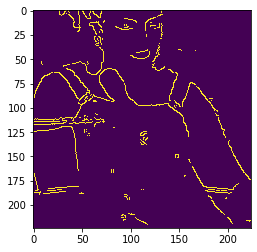

In [ ]:
idx=14
plt.imshow(CannyEdgeDetector(np.moveaxis(IMAGES_NEW[idx],0,-1)), interpolation="nearest")
plt.show()

In [ ]:
def split_train_valid(data,train_ratio):
  train_sz = int(data.shape[0]*train_ratio)
  train_data = data[:train_sz]
  val_data = data[train_sz:]
  return train_data, val_data

# Loss Functions

## Data Term

In [ ]:
def getSquaredLoss(input_img, output_img):
  #input_img, output_img: (1, 3, 224, 224)
  return (torch.sum((input_img-output_img)**2))/(224.0*224.0)

## Edge-Preserving Term + Regularization Term

In [ ]:
def getEdgeResponse(img):
  #assuming that img is (1, 3, 224, 224)
  img=img[0][0]+img[0][1]+img[0][2] #(224,224)
  img_open=F.unfold(img[None,None,:,:], kernel_size=224, padding=(3-1)//2) #(224*224, 9)
  return torch.sum(torch.abs(img_open[0]-img_open[0][:,4:5]), dim=1).reshape(224,224)  #(224,224)

In [ ]:
def otherLosses(input_img, output_img):
  #print("Here1")
  c1=20;c2=10;h=5;alpha=5;sigma_r=0.1;sigma_s=7;p_large=2;p_small=0.8
  mid=(h-1)//2
  #input_img, output_img: (1, 3, 224, 224)
  input_edge_response=getEdgeResponse(input_img)  #(224,224)
  output_edge_response=getEdgeResponse(output_img)  #(224,224)
  i=torch.moveaxis(input_img[0],0,-1).to("cpu")      #(224,224,3)
  edge_map=CannyEdgeDetector(i.numpy())               #(224,224)
  edge_map=torch.from_numpy(edge_map).to("cuda")       #(224,224)
  edge_loss=torch.sum(edge_map*((input_edge_response-output_edge_response)**2))/torch.sum(edge_map) #float
  #print("Here2")
  #finding w_ij_r
  input_img_YUV=cv2.cvtColor((255*i.numpy()).astype(np.uint8), cv2.COLOR_RGB2YUV).astype(np.float64)/255.0  #(224,224,3)
  input_img_YUV=torch.from_numpy(input_img_YUV).to("cuda")
  w_ij_r=torch.zeros(224*224, h*h, device="cuda")
  for i in range(3):
    temp=F.unfold(input_img_YUV[:,:,i][None,None,:,:],kernel_size=224,padding=mid)
    w_ij_r=w_ij_r+(temp[0]-temp[0][:,mid:mid+1])**2
  w_ij_r=torch.exp(-w_ij_r/(2*sigma_r*sigma_r)).float()   #(224*224, h*h)
  #print("Here3")
  #finding w_ij_sl=[i for i in range(-mid, mid+1)]
  l=[i for i in range(-mid, mid+1)]
  grid_x, grid_y=torch.meshgrid(torch.tensor(l,device="cuda"), torch.tensor(l,device="cuda"), indexing="ij")
  w_ij_s=(alpha*torch.exp(-(grid_x**2+grid_y**2)/(2*sigma_s*sigma_s))).reshape((1, h*h)).float()    #(h,h)
  #print("Here4")
  #finding p_i's
  large_indices=(input_edge_response<c1)*(output_edge_response-input_edge_response>c2)  #(224,224)
  small_indices=~large_indices    #(224,224)
  P_mat=torch.zeros(224,224,device="cuda")  #(224,224)
  P_mat[large_indices]=p_large    #(224,224)
  P_mat[small_indices]=p_small    #(224,224)
  P_mat=P_mat.reshape((224*224,1))
  #print("Here5")
  #L_p norm
  T=torch.zeros(224*224, h*h, device="cuda")
  for i in range(3):
    temp=F.unfold(output_img[0,i,:,:][None,None,...], kernel_size=224, padding=mid)
    T=T+torch.pow(1e-40+torch.abs(temp[0]-temp[0][:,mid:mid+1]), P_mat)
  w_ij=torch.zeros(224*224, h*h, device="cuda")
  large_idx=(P_mat==p_large).squeeze()
  small_idx=(P_mat==p_small).squeeze()
  w_ij[large_idx,:]=w_ij_s
  w_ij[small_idx,:]=w_ij_r[small_idx,:]
  regularization_loss=torch.sum(w_ij*T)/(224.0*224.0)
  return edge_loss, regularization_loss

## Total Loss Function

In [ ]:
def LOSS_FUNCTION(input_img, output_img):
  lambda_f=1; lambda_e=0.2
  data_term=getSquaredLoss(input_img, output_img)
  edge_preserving_term, regularization_term=otherLosses(input_img, output_img)
  return data_term + (lambda_f*regularization_term) + (lambda_e*edge_preserving_term)

In [ ]:
def getResidualBlock(in_ch, out_ch, dilation_factor):
    return nn.Sequential(
        nn.Conv2d(in_ch,out_ch,(3,3),dilation=dilation_factor,padding=dilation_factor),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch,out_ch,(3,3),dilation=dilation_factor,padding=dilation_factor),
        nn.BatchNorm2d(out_ch),
    )

def getConvolutionLayer(in_ch,out_ch,stride):
    if stride == 1:
        return nn.Sequential(
            nn.Conv2d(in_ch,out_ch,(3,3),stride=stride,padding="same"),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        ) 
    else:
        return nn.Sequential(
            nn.Conv2d(in_ch,out_ch,(3,3),stride=stride,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

def getDeconvolveLayer(in_ch,out_ch,stride):
    return nn.Sequential(
        nn.ConvTranspose2d(in_ch,out_ch,(3,3),stride=stride,padding = 1,output_padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )

class ImageTransformer(nn.Module):

  def __init__(self):
    super().__init__()

    self.layer1 = getConvolutionLayer(3,64,1)
    self.layer2 = getConvolutionLayer(64,64,1)
    self.layer3 = getConvolutionLayer(64,64,2)

    self.residual_block1 = getResidualBlock(64,64,2)
    self.residual_block2 = getResidualBlock(64,64,2)
    self.residual_block3 = getResidualBlock(64,64,4)
    self.residual_block4 = getResidualBlock(64,64,4)
    self.residual_block5 = getResidualBlock(64,64,8)
    self.residual_block6 = getResidualBlock(64,64,8)
    self.residual_block7 = getResidualBlock(64,64,16)
    self.residual_block8 = getResidualBlock(64,64,16)
    self.residual_block9 = getResidualBlock(64,64,1)
    self.residual_block10 = getResidualBlock(64,64,1)

    self.deconvolve11 = getDeconvolveLayer(64,64,2)

    self.layer11 = getConvolutionLayer(64,64,1)
    self.layer12 = nn.Conv2d(64,3,(3,3),stride=1,padding=1)
    

    print("Initialized model")

  def forward(self,image):

    output = self.layer1(image)
    output = self.layer2(output)
    output = self.layer3(output)

    output = F.relu((output+self.residual_block1(output)))
    output = F.relu((output+self.residual_block2(output)))
    output = F.relu((output+self.residual_block3(output)))
    output = F.relu((output+self.residual_block4(output)))
    output = F.relu((output+self.residual_block5(output)))
    output = F.relu((output+self.residual_block6(output)))
    output = F.relu((output+self.residual_block7(output)))
    output = F.relu((output+self.residual_block8(output)))
    output = F.relu((output+self.residual_block9(output)))
    output = F.relu((output+self.residual_block10(output)))

    output = self.deconvolve11(output)

    output = self.layer11(output)

    output = self.layer12(output)

    return image + output

In [ ]:
batch_sz = 1
lr = 1e-2
epochs = 15#

In [ ]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for idx, m in enumerate(model.modules()):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
          if idx == 2:
            std_dev = math.sqrt(12.0/(603.0))
          else:
            std_dev = math.sqrt((12.0/1152.0))
          
          nn.init.uniform_(m.weight.data,-std_dev,std_dev)
          m.bias.data.fill_(0.0)

        elif isinstance(m, (nn.BatchNorm2d)):

          m.weight.data.fill_(1.0)
          m.bias.data.fill_(0.0)
        # if you also want for linear layers ,add one more elif condition 

In [ ]:
model = ImageTransformer()
initialize_weights(model)
model.to("cuda")
images_train, images_val = split_train_valid(IMAGES_NEW[:2000],0.99)
Train_DataLoader = DataLoader(images_train,batch_size = batch_sz,num_workers=2,shuffle=True)
myOptim = optim.AdamW(model.parameters(),lr=lr)

Initialized model


In [ ]:
def train(epochs):
  # train_loss = []
  # val_loss = []

  # prev_loss = -10000

  for epoch in range(epochs):
    print("Epoch Number:",epoch)
    total_loss = 0
    # total_e_loss = 0
    # total_s_loss = 0

    for idx, images_batch in enumerate(Train_DataLoader):
        images_batch1 = images_batch.float()
        images_batch1 = images_batch1.to(DEVICE)
        images_batch1=images_batch1/255.0
        output = model.forward(images_batch1)

        loss = LOSS_FUNCTION(images_batch1, output)
        if idx%100==0:
          print("{}:{}".format(idx, loss))
        total_loss += loss.item()
        # total_e_loss += edge_l.item()
        # total_s_loss += smooth_l.item()

        myOptim.zero_grad()
        loss.backward()
        myOptim.step()
        del images_batch1
    total_loss = total_loss/images_train.shape[0]
    # total_e_loss = total_e_loss/images_train.shape[0]
    # total_s_loss = total_s_loss/images_train.shape[0]
    # train_loss.append(total_loss)

    print("After an epoch Loss: ",total_loss)
    # print("Smoothness Loss:",total_s_loss)
    # print("Edge Loss:",total_e_loss)

    # if prev_loss > loss:
    #   torch.save(model,"./gdrive/Shareddrives/CS663-Project/RKMODEL.pt")
    #   prev_loss = loss

    # if prev_loss == -10000:    
    #   prev_loss = loss
    torch.save(model,"./gdrive/Shareddrives/CS663-Project/RKMODEL_25-11-2021_{}.pt".format(epoch))

In [ ]:
# torch.autograd.set_detect_anomaly(True)

In [ ]:
train(epochs)

Epoch Number: 0
0:322.5987854003906
100:3.804903507232666
200:3.903360366821289
300:3.732339382171631
400:3.336240530014038
500:4.067846775054932
600:4.424531936645508
700:3.239927291870117
800:3.619211196899414
900:3.900084972381592
1000:3.800119400024414
1100:3.342984199523926
1200:3.2630887031555176
1300:2.785635232925415
1400:3.311908721923828
1500:3.395622730255127
1600:2.8581907749176025
1700:3.057359218597412
1800:3.914055347442627
1900:3.3910634517669678
After an epoch Loss:  6.063357802593347
Epoch Number: 1
0:3.619598388671875
100:3.2973580360412598
200:3.676362991333008
300:3.6537303924560547
400:3.7011663913726807
500:2.8920042514801025
600:3.117021322250366
700:3.374774932861328
800:3.233125686645508
900:3.916428804397583
1000:3.4250426292419434
1100:3.458040952682495
1200:3.87335467338562
1300:3.930018424987793
1400:3.2510011196136475
1500:3.6453511714935303
1600:2.0113141536712646
1700:2.3345351219177246
1800:3.1399006843566895
1900:2.9946706295013428
After an epoch Loss

In [ ]:
idx = 11
I=IMAGES_NEW[idx][None,:,:,:]/255.0
I=torch.from_numpy(I)
I=I.to(DEVICE)
im=model.forward(I.float())
im=im.to("cpu")
fig, axList=plt.subplots(1,2, figsize=(10,10))
axList[0].imshow(np.moveaxis(IMAGES_NEW[idx], 0, -1))
axList[1].imshow(np.moveaxis(im[0].detach().numpy(), 0, -1))
plt.show()

In [ ]:
im_scaled=((im-torch.min(im))/(torch.max(im)-torch.min(im)))
plt.imshow(torch.moveaxis(im_scaled[0],0,-1).detach().numpy())